In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
from utils.func_utils import accept, jacobian, autocovariance, get_log_likelihood, get_data, binarize, normal_kl
from utils.distributions import Gaussian, GMM, GaussianFunnel, gen_ring
from utils.layers import Linear, Parallel, Sequential, Zip, ScaleTanh
from utils.dynamics import Dynamics
from utils.sampler import propose
from utils.losses import get_loss, loss_mixed

In [27]:
tf.reset_default_graph()

In [28]:
size1 = 10
size2 = 10

x_dim = 2

gaussian = Gaussian(np.zeros(2,), np.array([[10., 0.], [0., 0.1]]))

def net_factory(x_dim, scope, factor):
    with tf.variable_scope(scope):
        net = Sequential([
            Zip([
                Linear(x_dim, size1, scope='embed_1', factor=0.33),
                Linear(x_dim, size1, scope='embed_2', factor=factor * 0.33),
                Linear(2, size1, scope='embed_3', factor=0.33),
                lambda _, *args, **kwargs: 0.
            ]),
            sum,
            tf.nn.relu,
            Linear(size1, size2, scope='linear_1'),
            tf.nn.relu,
            Parallel([
                Sequential([
                    Linear(size2, x_dim, scope='linear_s', factor=0.01), 
                    ScaleTanh(x_dim, scope='scale_s')
                ]),
                Linear(size2, x_dim, scope='linear_t', factor=0.01),
                Sequential([
                    Linear(size2, x_dim, scope='linear_f', factor=0.01),
                    ScaleTanh(x_dim, scope='scale_f'),
                ])
            ])
        ])
    return net

dynamics = Dynamics(
    x_dim, 
    gaussian.get_energy_function(), 
    T=5, 
    eps=0.1, 
    hmc=False, 
    eps_trainable=True, 
    net_factory=net_factory, 
    use_temperature=False
)


In [79]:
x = tf.placeholder(tf.float32, shape=(None, x_dim))
z = tf.sqrt(0.1) * tf.random_normal(tf.shape(x))

Lx, _, px, MHx = propose(x, dynamics, do_mh_step=True)
Lz, _, pz, MHz = propose(z, dynamics, do_mh_step=True)

loss = loss_mixed(x, Lx, px, scale=1.) + loss_mixed(z, Lz, pz, scale=1.)

In [80]:
lr = tf.placeholder(tf.float32, shape=())
global_step = tf.Variable(0., trainable=False)
learning_rate = tf.train.exponential_decay(lr, global_step,
                                           250, 0.96, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss)

In [81]:
samples = np.sqrt(0.1) * np.random.randn(200, 2)
L = []

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for t in range(10000):
    samples, loss_, _ = sess.run([MHx[0], loss, train_op], {x: samples, lr: 5e-3})
    L.append(loss_)
    if t % 100 == 0:
        print '%d/%d: Loss=%.2e' % (t, 5000, loss_)

0/5000: Loss=4.79e+01
100/5000: Loss=2.83e+01
200/5000: Loss=9.55e+00
300/5000: Loss=2.62e+00
400/5000: Loss=4.45e+00
500/5000: Loss=4.04e+00
600/5000: Loss=2.17e+00
700/5000: Loss=2.25e+00
800/5000: Loss=-6.58e+00
900/5000: Loss=-9.20e+00
1000/5000: Loss=-1.29e+01
1100/5000: Loss=-1.60e+01
1200/5000: Loss=-1.63e+01
1300/5000: Loss=-1.67e+01
1400/5000: Loss=-1.80e+01
1500/5000: Loss=-1.77e+01
1600/5000: Loss=-1.64e+01
1700/5000: Loss=-1.89e+01
1800/5000: Loss=-1.83e+01
1900/5000: Loss=-1.75e+01
2000/5000: Loss=-1.73e+01
2100/5000: Loss=-1.76e+01
2200/5000: Loss=-1.89e+01
2300/5000: Loss=-1.78e+01
2400/5000: Loss=-1.65e+01
2500/5000: Loss=-1.86e+01
2600/5000: Loss=-1.97e+01
2700/5000: Loss=-1.83e+01
2800/5000: Loss=-1.81e+01
2900/5000: Loss=-1.88e+01
3000/5000: Loss=-1.83e+01
3100/5000: Loss=-1.87e+01
3200/5000: Loss=-1.87e+01
3300/5000: Loss=-1.79e+01
3400/5000: Loss=-1.74e+01
3500/5000: Loss=-1.92e+01
3600/5000: Loss=-2.19e+01
3700/5000: Loss=-1.98e+01
3800/5000: Loss=-2.29e+01
3900/5

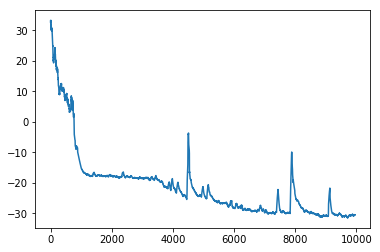

In [82]:
def smooth(x, k=25):
    n = len(x)
    return [np.mean(x[t: t+k]) for t in range(n - k)]
plt.plot(smooth(L, k=50))

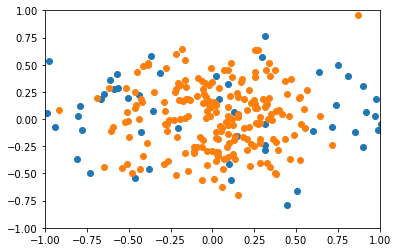

In [91]:
samples = np.sqrt(0.1) * np.random.randn(200, 2)
S = gaussian.get_samples(200)

plt.scatter(S[:, 0], S[:, 1])
plt.scatter(samples[:, 0], samples[:, 1])
plt.xlim(-1, 1)
plt.ylim(-1, 1)
for t in range(200):
    final_samples.append(np.copy(samples))
    samples = sess.run(MHx[0], {x: samples})

In [34]:
def autocovariance(X, tau=0):
    dT, dN, dX = np.shape(X)
    s = 0.
    for t in range(dT - tau):
        x1 = X[t, :, :]
        x2 = X[t+tau, :, :]

        s += np.sum(x1 * x2) / dN

    return s / (dT - tau)

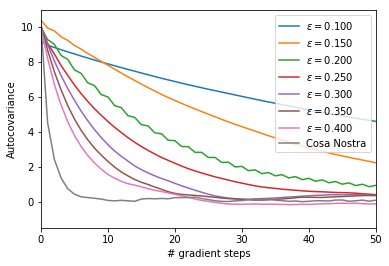

In [84]:
for eps in np.arange(0.1, 0.4, 0.05):
    H = get_hmc_samples(eps)
    plt.plot([autocovariance(H, tau=t) for t in range(199)], label='$\epsilon=%.3f$' % eps)
plt.plot(np.abs([autocovariance(np.array(final_samples), tau=t) for t in range(199)]), label='Cosa Nostra')
plt.xlim(0, 50)
plt.xlabel('# gradient steps')
plt.ylabel('Autocovariance')
plt.legend()

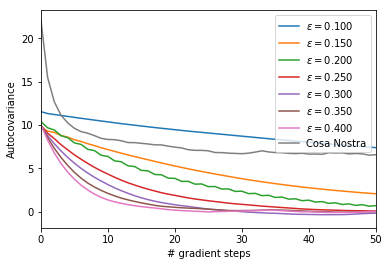

In [78]:
for eps in np.arange(0.1, 0.4, 0.05):
    H = get_hmc_samples(eps)
    plt.plot([autocovariance(H, tau=t) for t in range(199)], label='$\epsilon=%.3f$' % eps)
plt.plot(np.abs([autocovariance(np.array(final_samples2), tau=t) for t in range(199)]), label='Cosa Nostra')
plt.xlim(0, 50)
plt.xlabel('# gradient steps')
plt.ylabel('Autocovariance')
plt.legend()

In [37]:
def get_hmc_samples(eps):
    hmc_dynamics = Dynamics(x_dim, gaussian.get_energy_function(), T=5, eps=eps, hmc=True)
    hmc_x = tf.placeholder(tf.float32, shape=(None, x_dim))
    _, _, _, hmc_MH = propose(hmc_x, hmc_dynamics, do_mh_step=True)
    samples = gaussian.get_samples(n=200)
    final_samples = []
    
    for t in range(200):
        final_samples.append(np.copy(samples))
        samples = sess.run(hmc_MH[0], {hmc_x: samples})
    
    return np.array(final_samples)

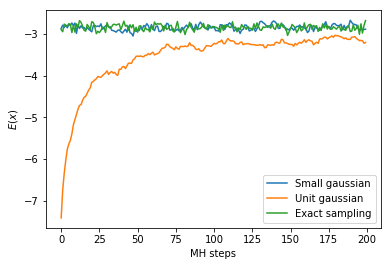

In [89]:
from utils.func_utils import get_log_likelihood
F = np.array(final_samples)
G = np.array(final_samples2)
plt.plot([get_log_likelihood(F[t, :, :], gaussian) for t in range(200)], label='Small gaussian')
plt.plot([get_log_likelihood(G[t, :, :], gaussian) for t in range(200)], label='Unit gaussian')
plt.plot([get_log_likelihood(gaussian.get_samples(200), gaussian) for t in range(200)], label='Exact sampling')
plt.xlabel('MH steps')
plt.ylabel('$E(x)$')
plt.legend()

In [93]:
w = tf.placeholder(tf.float32, shape=(None, 5))
v = tf.placeholder(tf.float32, shape=(None, 5))

w / v

<tf.Tensor 'div_20:0' shape=(?, 5) dtype=float32>

In [94]:
sess.run(w / v, {w: [[1, 2, 3, 4, 5]], v: [[2, 2, 5, 2, 2]]})

array([[ 0.5       ,  1.        ,  0.60000002,  2.        ,  2.5       ]], dtype=float32)